### Make Plots from Climatologies Produced with ObsFlow

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import xscen as xs
import cartopy.crs as ccrs
import cartopy
from xscen.config import CONFIG
from pathlib import Path

%matplotlib inline
out_dir = '/scen3/braun/data/obs_synthese23/image'
# get the ObsFlow config and project catalog
xs.load_config('/home/braun/python/obsflow/paths_obs.yml', '/home/braun/python/obsflow/config_obs.yml', verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog('/scen3/braun/data/obs_synthese23/pcat_obs.json')
ds_dict = pcat.search(processing_level='climatology').to_dataset_dict(**CONFIG['to_dataset_dict'])
# remove AHCCD for now
ds_dict = {k: v for k, v in sorted(ds_dict.items()) if 'AHCCD' not in k}

for ds_id, ds_in in ds_dict.items():
    # inspect the dataset
    # print(f'{ds_id}: {ds_in.period.values}')
    # print(f'{ds_id}: {list(ds_in.data_vars.keys())}')
    print(f'{ds_id}: {list(ds_in.dims.keys())}')

display(ds_dict['GovCan_RDRS_NAM.Quebec.climatology.fx'])
display(ds_dict['GovCan_RDRS_NAM.Quebec.climatology.AS-JAN'])
display(ds_dict['GovCan_RDRS_NAM.Quebec.climatology.QS-DEC'])
display(ds_dict['GovCan_RDRS_NAM.Quebec.climatology.MS'])


INFO:xscen.config:Updated the config with /home/braun/python/obsflow/paths_obs.yml.
INFO:xscen.config:Updated the config with /home/braun/python/obsflow/config_obs.yml.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


ECMWF_ERA5-Land_NAM.Quebec.climatology.AS-JAN: ['lat', 'lon', 'period', 'year']
ECMWF_ERA5-Land_NAM.Quebec.climatology.MS: ['lat', 'lon', 'month', 'period']
ECMWF_ERA5-Land_NAM.Quebec.climatology.QS-DEC: ['lat', 'lon', 'period', 'season']
ECMWF_ERA5-Land_NAM.Quebec.climatology.fx: ['lat', 'lon', 'month', 'period', 'season']
GovCan_RDRS_NAM.Quebec.climatology.AS-JAN: ['rlat', 'rlon', 'period', 'year']
GovCan_RDRS_NAM.Quebec.climatology.MS: ['rlat', 'rlon', 'month', 'period']
GovCan_RDRS_NAM.Quebec.climatology.QS-DEC: ['rlat', 'rlon', 'period', 'season']
GovCan_RDRS_NAM.Quebec.climatology.fx: ['rlat', 'rlon', 'month', 'period', 'season']
MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.AS-JAN: ['rlat', 'rlon', 'period', 'year']
MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.MS: ['rlat', 'rlon', 'month', 'period']
MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.QS-DEC: ['rlat', 'rlon', 'period', 'season']


<xarray.Dataset>
Dimensions:          (rlat: 191, rlon: 164, month: 12, period: 2, season: 4)
Coordinates:
    lat              (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
    lon              (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
  * month            (month) <U3 'JAN' 'FEB' 'MAR' 'APR' ... 'OCT' 'NOV' 'DEC'
  * period           (period) <U9 '1981-2010' '1991-2018'
  * rlat             (rlat) float32 -11.61 -11.52 -11.43 ... 5.31 5.4 5.49
  * rlon             (rlon) float32 366.5 366.6 366.7 ... 381.0 381.1 381.2
    rotated_pole     float32 ...
  * season           (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/18)
    tas_mean_ann     (period, rlat, rlon) float32 dask.array<chunksize=(2, 30, 30), meta=np.ndarray>
    tas_mean_mon     (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tas_mean_sea     (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tas_std_ann      (period, rlat, rlon) float32 dask.array<chunksize=(2, 30, 30), meta=np.ndarray>
    tas_std_mon      (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tas_std_sea      (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    ...               ...
    tasmin_mean_ann  (period, rlat, rlon) float32 dask.array<chunksize=(2, 30, 30), meta=np.ndarray>
    tasmin_mean_mon  (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tasmin_mean_sea  (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tasmin_std_ann   (period, rlat, rlon) float32 dask.array<chunksize=(2, 30, 30), meta=np.ndarray>
    tasmin_std_mon   (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tasmin_std_sea   (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-12-31 00:00:00
    cat:date_start:          1980-01-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1
    cat:variable:            tasmax_std_mon,tas_std_mon,tas_mean_mon,tasmax_s...

<xarray.Dataset>
Dimensions:               (rlat: 191, rlon: 164, period: 2, year: 1)
Coordinates:
    lat                   (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
    lon                   (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
  * period                (period) <U9 '1981-2010' '1991-2018'
  * rlat                  (rlat) float32 -11.61 -11.52 -11.43 ... 5.31 5.4 5.49
  * rlon                  (rlon) float32 366.5 366.6 366.7 ... 381.0 381.1 381.2
    rotated_pole          float32 ...
  * year                  (year) <U3 'ANN'
Data variables:
    tg_mean               (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tg_mean_std           (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tn_days_above_20      (period, year, rlat, rlon) float64 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tn_days_above_20_std  (period, year, rlat, rlon) float64 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tn_mean               (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tn_mean_std           (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tx_mean               (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
    tx_mean_std           (period, year, rlat, rlon) float32 dask.array<chunksize=(2, 1, 30, 30), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-01-01 00:00:00
    cat:date_start:          1980-01-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    realm:                   atmos
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1

<xarray.Dataset>
Dimensions:       (rlat: 191, rlon: 164, period: 2, season: 4)
Coordinates:
    lat           (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
  * period        (period) <U9 '1981-2010' '1991-2018'
  * rlat          (rlat) float32 -11.61 -11.52 -11.43 -11.34 ... 5.31 5.4 5.49
  * rlon          (rlon) float32 366.5 366.6 366.7 366.8 ... 381.0 381.1 381.2
    rotated_pole  float32 ...
  * season        (season) <U3 'MAM' 'JJA' 'SON' 'DJF'
Data variables:
    tg_mean       (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tg_mean_std   (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tn_mean       (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tn_mean_std   (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tx_mean       (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
    tx_mean_std   (period, season, rlat, rlon) float32 dask.array<chunksize=(2, 4, 30, 30), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-12-01 00:00:00
    cat:date_start:          1980-03-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    realm:                   atmos
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1

<xarray.Dataset>
Dimensions:       (rlat: 191, rlon: 164, month: 12, period: 2)
Coordinates:
    lat           (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(191, 164), meta=np.ndarray>
  * month         (month) <U3 'JAN' 'FEB' 'MAR' 'APR' ... 'OCT' 'NOV' 'DEC'
  * period        (period) <U9 '1981-2010' '1991-2018'
  * rlat          (rlat) float32 -11.61 -11.52 -11.43 -11.34 ... 5.31 5.4 5.49
  * rlon          (rlon) float32 366.5 366.6 366.7 366.8 ... 381.0 381.1 381.2
    rotated_pole  float32 ...
Data variables:
    tg_mean       (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tg_mean_std   (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tn_mean       (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tn_mean_std   (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tx_mean       (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
    tx_mean_std   (period, month, rlat, rlon) float32 dask.array<chunksize=(2, 12, 30, 30), meta=np.ndarray>
Attributes: (12/35)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    cat:_data_format_:       zarr
    cat:date_end:            2018-12-01 00:00:00
    cat:date_start:          1980-01-01 00:00:00
    cat:domain:              Quebec
    ...                      ...
    realm:                   atmos
    source:                  RDRS v2.1
    table_date:              12 December 2022
    table_id:                EC
    type:                    reconstruction
    version:                 v2.1

<xarray.Dataset>
Dimensions:          (lat: 179, lon: 230, month: 12, period: 6, season: 4)
Coordinates:
  * lat              (lat) float32 44.9 45.0 45.1 45.2 ... 62.4 62.5 62.6 62.7
  * lon              (lon) float32 -79.9 -79.8 -79.7 -79.6 ... -57.2 -57.1 -57.0
  * month            (month) <U3 'JAN' 'FEB' 'MAR' 'APR' ... 'OCT' 'NOV' 'DEC'
  * period           (period) <U9 '1951-1980' '1961-1990' ... '1991-2020'
  * season           (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/18)
    tas_mean_ann     (period, lat, lon) float32 dask.array<chunksize=(6, 179, 230), meta=np.ndarray>
    tas_mean_mon     (period, month, lat, lon) float32 dask.array<chunksize=(6, 12, 179, 230), meta=np.ndarray>
    tas_mean_sea     (period, season, lat, lon) float32 dask.array<chunksize=(6, 4, 179, 230), meta=np.ndarray>
    tas_std_ann      (period, lat, lon) float32 dask.array<chunksize=(6, 179, 230), meta=np.ndarray>
    tas_std_mon      (period, month, lat, lon) float32 dask.array<chunksize=(6, 12, 179, 230), meta=np.ndarray>
    tas_std_sea      (period, season, lat, lon) float32 dask.array<chunksize=(6, 4, 179, 230), meta=np.ndarray>
    ...               ...
    tasmin_mean_ann  (period, lat, lon) float32 dask.array<chunksize=(6, 179, 230), meta=np.ndarray>
    tasmin_mean_mon  (period, month, lat, lon) float32 dask.array<chunksize=(6, 12, 179, 230), meta=np.ndarray>
    tasmin_mean_sea  (period, season, lat, lon) float32 dask.array<chunksize=(6, 4, 179, 230), meta=np.ndarray>
    tasmin_std_ann   (period, lat, lon) float32 dask.array<chunksize=(6, 179, 230), meta=np.ndarray>
    tasmin_std_mon   (period, month, lat, lon) float32 dask.array<chunksize=(6, 12, 179, 230), meta=np.ndarray>
    tasmin_std_sea   (period, season, lat, lon) float32 dask.array<chunksize=(6, 4, 179, 230), meta=np.ndarray>
Attributes: (12/31)
    Conventions:             CF-1.9
    cat:_data_format_:       zarr
    cat:date_end:            2022-09-30 00:00:00
    cat:date_start:          1950-01-01 00:00:00
    cat:domain:              Quebec
    cat:frequency:           fx
    ...                      ...
    project:                 era5-land
    realm:                   atmos
    source:                  ERA5-Land
    table_id:                ECMWF
    type:                    reconstruction
    cat:variable:            tasmax_std_mon,tas_std_mon,tas_mean_mon,tasmax_s...

tas_mean_ann: ('period', 'lat', 'lon')
tas_mean_ann: []
tas_mean_mon: ('period', 'month', 'lat', 'lon')
tas_mean_mon: ['month']
tas_mean_sea: ('period', 'season', 'lat', 'lon')
tas_mean_sea: ['season']
tas_std_ann: ('period', 'lat', 'lon')
tas_std_ann: []
tas_std_mon: ('period', 'month', 'lat', 'lon')
tas_std_mon: ['month']
tas_std_sea: ('period', 'season', 'lat', 'lon')
tas_std_sea: ['season']
tasmax_mean_ann: ('period', 'lat', 'lon')
tasmax_mean_ann: []
tasmax_mean_mon: ('period', 'month', 'lat', 'lon')
tasmax_mean_mon: ['month']
tasmax_mean_sea: ('period', 'season', 'lat', 'lon')
tasmax_mean_sea: ['season']
tasmax_std_ann: ('period', 'lat', 'lon')
tasmax_std_ann: []
tasmax_std_mon: ('period', 'month', 'lat', 'lon')
tasmax_std_mon: ['month']
tasmax_std_sea: ('period', 'season', 'lat', 'lon')
tasmax_std_sea: ['season']
tasmin_mean_ann: ('period', 'lat', 'lon')
tasmin_mean_ann: []
tasmin_mean_mon: ('period', 'month', 'lat', 'lon')
tasmin_mean_mon: ['month']
tasmin_mean_sea: ('period', 

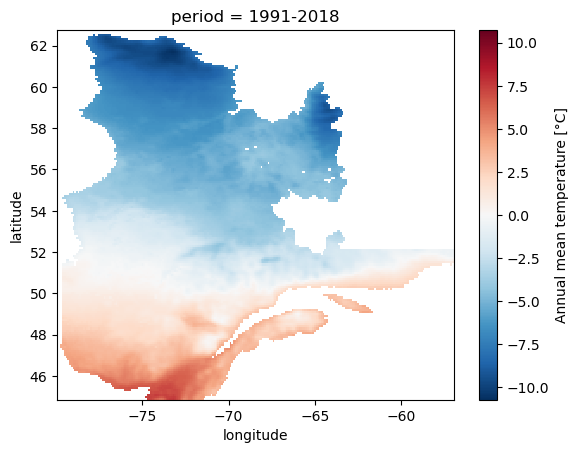

In [7]:
#ds = ds_dict['GovCan_RDRS_NAM.Quebec.climatology.fx']
ds = ds_dict['ECMWF_ERA5-Land_NAM.Quebec.climatology.fx']
#ds = ds_dict['GovCan_AHCCD_CAN_fx_climatology.zarr']
#ds = ds_dict['MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.fx']
#ds = ds_dict['MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.QS-DEC']
display(ds)
for ind in ds.data_vars.values():
    print(f'{ind.name}: {ind.dims}')
    sp_dim = [dim for dim in ind.dims if dim not in [v[0] for v in ds.cf.axes.values()] + ['period']]
    print(f'{ind.name}: {sp_dim}')

print([v[0] for v in ds.cf.axes.values()]) #.append('period'))

ds.cf.axes.values()
ds.tas_mean_ann.sel(period='1991-2018').plot(y='lat', x='lon')
#ds.tg_mean.sel(period='1980-1985', season='MAM').plot(y='rlat', x='rlon')


In [12]:
# Plot the climatologies
for ds_id, ds_in in ds_dict.items():
    # print(f'{ds_id}: {ds_in.period.values}')
    # print(f'{ds_id}: {list(ds_in.data_vars.keys())}')

    # TODO This is just a fix for now
    if 'MRCC' in ds_id:
        ds_in.attrs['source'] = 'CRCM5-ERAint'
    #if 'MRCC' not in ds_id: continue
    #if 'ECMWF_ERA5-Land_NAM.Quebec.climatology.fx' not in ds_id: continue

    # make a plot for each period in the dataset
    print(f'Doing: {ds_id}')
    #display(ds_in)
    for period in ds_in.period.values:
        for ind in ds_in.data_vars.values():
            plot_id = f"{ind.attrs['long_name'].lower()}_{ds_in.attrs['source']}_{period}"
            print(f'\tPlotting {ind.name}: {plot_id} ...')
            #display(ind)
            # print(f'{ds_id}: {var} \n\t{ds_in[var].attrs["long_name"]}')

            # inspect the variable and determine settings for plotting
            tmp_dim = [dim for dim in ind.dims if dim not in ['lat', 'lon', 'rlat', 'rlon', 'period']] #[v[0] for v in ds.cf.axes.values()] + ['period']]
            if not tmp_dim: tmp_dim = [1]
            # select the data for annual and sort for seasonal
            sel_kwargs = {'year': 'ANN'} if tmp_dim[0] == 'year' else {}
            if tmp_dim[0] == 'season': sel_kwargs = {'season': ['DJF', 'MAM', 'JJA', 'SON']}
            # how to arrange subplots
            col = {1: None, 'year': None, 'season': 'season', 'month': 'month'}
            col_wrap = {1: None, 'year': None, 'season': 2, 'month': 3}
            # colors to use
            if 'std' in ind.name: cmap = 'afmhot_r'
            elif any(s in ind.name for s in ['tg', 'tn', 'tx', 'tas']): cmap = 'RdBu_r'

            # make the plot
            print(f'\t{tmp_dim[0]} - {col[tmp_dim[0]]} - {col_wrap[tmp_dim[0]]}')
            frame = ind.sel(period=period, **sel_kwargs).plot.contourf(transform=ccrs.PlateCarree(),
                x='lon', y='lat',
                col=col[tmp_dim[0]], col_wrap=col_wrap[tmp_dim[0]],
                subplot_kws={'projection': ccrs.LambertConformal()},
                #cmap='RdBu_r', levels=20
                cmap=cmap, levels=20,
                add_labels=False,
            );

            # get the figure object to add a title, coastlines, configure the axes
            if isinstance(frame, xr.plot.facetgrid.FacetGrid): fig = frame.fig
            if isinstance(frame, cartopy.mpl.contour.GeoContourSet): fig = frame.axes.figure

            fig.suptitle(f"{ind.attrs['long_name'].capitalize()} - {ds_in.attrs['source']} ({period})", y=1.02, wrap=True);

            for ax in fig.axes:
                #print(f'{ax} which is a {type(ax)}')
                if isinstance(ax, cartopy.mpl.geoaxes.GeoAxes):
                    ax.coastlines()
                    ax.margins(0)
                    # TODO This is just a fix for CRCM5-ERAint
                    if 'MRCC' in ds_id:
                        ax.set_extent([-150, -40, 24, 70], crs=ccrs.PlateCarree())
                    else:
                        ax.set_extent([-79, -60, 45, 61], crs=ccrs.PlateCarree())

            # save the figure and close it
            out_dir = Path('/scen3/braun/data/obs_synthese23/image') / period
            if not out_dir.exists(): out_dir.mkdir(parents=True, exist_ok=True)
            fig.savefig(f"{out_dir}/{plot_id}.png".replace(' ', '_'), bbox_inches='tight', dpi=300)
            #display(fig
            plt.close(fig)

Doing: ECMWF_ERA5-Land_NAM.Quebec.climatology.AS-JAN
	Plotting tg_mean: 30-year mean of annual mean of daily mean temperature_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tg_mean_std: 30-year std of annual mean of daily mean temperature_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tn_days_above_20: 30-year mean of annual number of tropical nights (tmin > 20 degc)_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tn_days_above_20_std: 30-year std of annual number of tropical nights (tmin > 20 degc)_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tn_mean: 30-year mean of annual mean of daily minimum temperature_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tn_mean_std: 30-year std of annual mean of daily minimum temperature_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tx_mean: 30-year mean of annual mean of daily maximum temperature_ERA5-Land_1951-1980 ...
	year - None - None
	Plotting tx_mean_std: 30-year std of annual mean of daily maximum t

/exec/braun/.conda/envs/obsflow/lib/python3.9/site-packages/shapely/geometry/multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/exec/braun/.conda/envs/obsflow/lib/python3.9/site-packages/shapely/geometry/multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


	Plotting tas_mean_sea: seasonal mean temperature_CRCM5-ERAint_1980-1985 ...
	season - season - 2
	Plotting tas_std_ann: intra annual standard deviation of daily mean temperature_CRCM5-ERAint_1980-1985 ...
	1 - None - None
	Plotting tas_std_mon: intra monthly standard deviation of daily mean temperature_CRCM5-ERAint_1980-1985 ...
	month - month - 3
	Plotting tas_std_sea: intra seasonal standard deviation of daily mean temperature_CRCM5-ERAint_1980-1985 ...
	season - season - 2


matplotlib.figure.Figure

KeyError: 'key=MRCC5_ECMWF-ERAint75_OURANOS_CRCM5_historical_NAM-22_bcs.NAM-22.climatology.AS-JAN not found in catalog. You can access the list of valid keys via the .keys() method.'

In [115]:
import datetime

print([datetime.date(2000, m, 1).strftime('%^b') for m in range(1, 13)])

['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']


### testing some aggregation (should go to Testing_reference_sim_bcs.ipynb)

In [8]:
import xarray as xr
from dask.distributed import Client
#import hvplot.xarray

ds = xr.open_dataset('/scen3/braun/data/obs_synthese23/extracted/ECMWF_ERA5-Land_NAM_D_extracted.zarr', engine='zarr')
ds

<xarray.Dataset>
Dimensions:  (lat: 179, lon: 230, time: 26571)
Coordinates:
  * lat      (lat) float32 44.9 45.0 45.1 45.2 45.3 ... 62.3 62.4 62.5 62.6 62.7
  * lon      (lon) float32 -79.9 -79.8 -79.7 -79.6 ... -57.3 -57.2 -57.1 -57.0
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-09-30
Data variables:
    crs      int64 ...
    pr       (time, lat, lon) float32 ...
    tas      (time, lat, lon) float32 ...
    tasmax   (time, lat, lon) float32 ...
    tasmin   (time, lat, lon) float32 ...
Attributes: (12/27)
    Conventions:             CF-1.9
    cat:_data_format_:       zarr
    cat:domain:              Quebec
    cat:frequency:           day
    cat:id:                  ECMWF_ERA5-Land_NAM
    cat:institution:         ECMWF
    ...                      ...
    processing_level:        raw
    project:                 era5-land
    realm:                   atmos
    source:                  ERA5-Land
    table_id:                ECMWF
    type:                    reconstruction

In [11]:
with Client(n_workers=4, threads_per_worker=2, memory_limit='10GB'):
    ds_mon = ds.chunk({'time': 300}).resample(time='1MS').mean()
ds_mon

/exec/braun/.conda/envs/obsflow/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43971 instead
  warnings.warn(
2023-08-08 21:20:37,801 - distributed.nanny - ERROR - Failed to start process
Traceback (most recent call last):
  File "/exec/braun/.conda/envs/obsflow/lib/python3.9/site-packages/distributed/nanny.py", line 432, in instantiate
    result = await self.process.start()
  File "/exec/braun/.conda/envs/obsflow/lib/python3.9/site-packages/distributed/nanny.py", line 691, in start
    self.init_result_q = init_q = get_mp_context().Queue()
  File "/exec/braun/.conda/envs/obsflow/lib/python3.9/multiprocessing/context.py", line 103, in Queue
    return Queue(maxsize, ctx=self.get_context())
  File "/exec/braun/.conda/envs/obsflow/lib/python3.9/multiprocessing/queues.py", line 43, in __init__
    self._rlock = ctx.Lock()
  File "/exec/braun/.conda/envs/obsflow/lib/

OSError: [Errno 12] Cannot allocate memory